In [1]:
'''
# Description

This code shows an example of feature engineering and feature selection prior to modeling.
The data used is a dummy dataset representing human performance, taskload and physiological variables through time,
it is generated to be a plausible representation of a real study, but the results should not be taken as a conclusion
or valid analysis for human performance. 

The objective of this exercise is to exemplify a feature engineering and selection process, and then using the results 
as an input for a machine learning model. 

# Feature engineering
Feature engineering involves generating new variables out of the original dataset. This can be done by the use of 
certain function or transformation, based on domain knowledge, descriptive analytics, transformations, or other methods.
Common ones include statistical measurements such as mean and standard deviation, including their 
"rolling" version when several time periods are available. Feature engineering can help in the data science process 
by helping uncover information that has more predictive power than the original variables. As an example, the probability 
of default for a loan might be associated more with a clients variability in their checking account than the total 
cash balance in it. To discover this association, we would have to compute the variance or standard deviation of the 
checking account balances over time. In the rolling version, this could be the variance of the last 3,6, or 12 months prior 
to the time of analysis.  

* Note: feature engineering can be understood as the complete process of data cleaning, transformation, dimensionality 
reduction, and others. In this case, it refers to the process of generating new variables. 

# Feature selection / dimensionality reduction
Feature selection aims at reducing the dimensionality of data to avoid potential negative aspects of working with it 
(curse of dimensionality, multicollinearity, etc.)To achieve this, we try to select a subset of features from the data that retains the highest amount of information
(many times represented as variance). There are several techniques related to this process, here we use a combination of 
three: ANOVA F-score(nominal target, ratio features), Variance Inflation Factor, and a Recursive Feature Elimination wrapper. The method executes the 
approaches, records the result, and selects the feature based on a composite of the results, in this case, the mean. 


# Model 
We use a mulitnomial bayesian model to test in this code. We compare the results of the feature engineering final features
with the original features to test the effectiveness of the approach. The comarison is made using several model performance 
metrics, including accuracy, precision, sensitivity/recall, specificity and F1 Score, with confusion matrix visualizations. 
'''

'\n# Description\n\nThis code shows an example of feature engineering and feature selection prior to modeling.\nThe data used is a dummy dataset representing human performance, taskload and physiological variables through time,\nit is generated to be a plausible representation of a real study, but the results should not be taken as a conclusion\nor valid analysis for human performance. \n\nThe objective of this exercise is to exemplify a feature engineering and selection process, and then using the results \nas an input for a machine learning model. \n\n# Feature engineering\nFeature engineering involves generating new variables out of the original dataset. This can be done by the use of \ncertain function or transformation, based on domain knowledge, descriptive analytics, transformations, or other methods.\nCommon ones include statistical measurements such as mean and standard deviation, including their \n"rolling" version when several time periods are available. Feature engineering 

In [30]:
# Imports
import pandas as pd
import numpy as np
import sklearn
import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

from FeatureSelection import FeatureSelector

start_time=time.time()

In [31]:
# We import the dataset
raw_data = pd.read_csv('Dummy_Data_Set_Bayes.csv')
raw_data.head()

,TASKLOAD,TIME_ELAPSED,RMSSD,HR,EDA,BLINK RATE,PCPS,TIME_COMP,ACCURACY
0,Low,1,0.929,71,2,17,3.912,0,79
1,Low,2,0.918,61,1,18,3.791,3,94
2,Low,3,0.904,61,1,18,3.768,5,75
3,Low,4,0.885,70,2,20,3.886,0,77
4,Low,5,0.921,78,1,19,3.848,0,84


In [32]:
'''
Feature engineering
We calculate several "synthetic" variables on the data:mean, std, min, max, median
'''
# Rolling stats function
def rolling_stats(dataframe, columns,periods):
    for x in columns:
        for y in periods:
            dataframe[x+'_mean_'+str(y)]=dataframe[x].rolling(y).mean()
            dataframe[x+'_std_'+str(y)]=dataframe[x].rolling(y).std()
            #dataframe[x+'_min_'+str(y)]=dataframe[x].rolling(y).min()
            #dataframe[x+'_max_'+str(y)]=dataframe[x].rolling(y).max()
            dataframe[x+'_median_'+str(y)]=dataframe[x].rolling(y).median()
    
# we declare variables and periods to calculate rolling stats
features=['RMSSD','HR','EDA','BLINK RATE','PCPS','ACCURACY']
period=[3,6]

# Executing function
rolling_stats(dataframe=raw_data,columns=features,periods=period)

# We change Nan to zero
raw_data=raw_data.fillna(0)            
raw_data

,TASKLOAD,TIME_ELAPSED,RMSSD,HR,EDA,BLINK RATE,PCPS,TIME_COMP,ACCURACY,RMSSD_mean_3,...,PCPS_median_3,PCPS_mean_6,PCPS_std_6,PCPS_median_6,ACCURACY_mean_3,ACCURACY_std_3,ACCURACY_median_3,ACCURACY_mean_6,ACCURACY_std_6,ACCURACY_median_6
0,Low,1,0.929,71,2,17,3.912,0,79,0.000000,...,0.000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,Low,2,0.918,61,1,18,3.791,3,94,0.000000,...,0.000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,Low,3,0.904,61,1,18,3.768,5,75,0.917000,...,3.791,0.000000,0.000000,0.0000,82.666667,10.016653,79.0,0.000000,0.000000,0.0
3,Low,4,0.885,70,2,20,3.886,0,77,0.902333,...,3.791,0.000000,0.000000,0.0000,82.000000,10.440307,77.0,0.000000,0.000000,0.0
4,Low,5,0.921,78,1,19,3.848,0,84,0.903333,...,3.848,0.000000,0.000000,0.0000,78.666667,4.725816,77.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,High,328,1.250,114,6,13,4.278,15,19,1.260000,...,4.223,4.247333,0.040267,4.2655,27.333333,7.234178,31.0,19.000000,10.862780,17.0
992,High,329,1.280,113,5,11,4.288,11,19,1.273333,...,4.278,4.250833,0.043130,4.2700,23.000000,6.928203,19.0,19.666667,10.689559,19.0
993,High,330,1.270,104,6,10,4.195,13,18,1.266667,...,4.278,4.239333,0.047857,4.2495,18.666667,0.577350,19.0,20.500000,10.251829,19.0
994,High,331,1.360,103,6,11,4.209,11,11,1.303333,...,4.209,4.228167,0.045341,4.2160,16.000000,4.358899,18.0,21.666667,8.189424,19.0


In [33]:
'''
Feature selection
'''

# selecting the relevant features, excluding the ones not selected
features_df=pd.DataFrame()
my_cols=set(raw_data.columns)
my_cols.remove('TASKLOAD')
my_cols.remove('TIME_ELAPSED')
my_cols = list(my_cols)
features_df=raw_data[my_cols]
target=raw_data['TASKLOAD']

# We apply the feature selector module 
# Set up the class
selector = FeatureSelector()

# We configure the code to select a certain amount of features.
# The Variance Inflation Factor is typically set up as 10, we can be more permissive by setting it up to 15
# VIF and RFE require an a-priori number of variables to keep, we give it 10 in this case
selected_features = selector.selection(features_df, target, n_features_to_select=20, vif_threshold=20)

selected_features



,PCPS,HR_mean_3,RMSSD_std_3,EDA,TIME_COMP,RMSSD_mean_3,RMSSD,ACCURACY,EDA_mean_6,HR,PCPS_std_3,HR_median_6,ACCURACY_median_3,ACCURACY_mean_6
0,3.912,0.000000,0.000000,2,0,0.000000,0.929,79,0.000000,71,0.000000,0.0,0.0,0.000000
1,3.791,0.000000,0.000000,1,3,0.000000,0.918,94,0.000000,61,0.000000,0.0,0.0,0.000000
2,3.768,64.333333,0.012530,1,5,0.917000,0.904,75,0.000000,61,0.077358,0.0,79.0,0.000000
3,3.886,64.000000,0.016563,2,0,0.902333,0.885,77,0.000000,70,0.062554,0.0,77.0,0.000000
4,3.848,69.666667,0.018009,1,0,0.903333,0.921,84,0.000000,78,0.060233,0.0,77.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,4.278,115.000000,0.026458,6,15,1.260000,1.250,19,5.333333,114,0.051052,115.5,31.0,19.000000
992,4.288,113.666667,0.020817,5,11,1.273333,1.280,19,5.333333,113,0.035000,114.0,19.0,19.666667
993,4.195,110.333333,0.015275,6,13,1.266667,1.270,18,5.500000,104,0.051052,113.5,19.0,20.500000
994,4.209,106.666667,0.049329,6,11,1.303333,1.360,11,5.666667,103,0.050143,113.5,18.0,21.666667


In [34]:
# Wwe can observe the results of the selection criteria.
selector.result

,EDA_mean_3,PCPS_mean_6,PCPS_median_6,EDA_std_6,HR_std_6,HR_median_3,ACCURACY_std_6,PCPS,RMSSD_median_3,HR_mean_3,...,PCPS_std_3,BLINK RATE_std_6,HR_median_6,ACCURACY_std_3,ACCURACY_median_3,ACCURACY_mean_6,RMSSD_median_6,RMSSD_std_6,EDA_std_3,ACCURACY_median_6
ANOVA,1,0,0,0,0,1,0,1,1,1,...,0,0,1,0,1,1,0,0,0,1
VIF,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
RFE,0,0,0,0,0,0,1,1,0,1,...,1,0,1,0,1,1,1,0,0,0


In [35]:
'''
Bayesian Model

We build the model with the 12 variables selected

'''
start_time=time.time()
# we divide data in train and test 
x_train,x_test,y_train,y_test=train_test_split(selected_features,target,test_size=0.25,random_state=42)

# model training
model=MultinomialNB()
model.fit(x_train,y_train)

print(" training executed in %s seconds "% (time.time()-start_time))

# with 129 variables original: training executed in 0.02599954605102539 seconds
# With around 40 original variables, using 12 selected ones: training executed in 0.00799870491027832 seconds

 training executed in 0.007004499435424805 seconds 


In [36]:
start_time=time.time()

# execute prediction
y_pred=model.predict(x_test)
y_pred

# accuracy
accuracy=accuracy_score(y_test,y_pred)
accuracy

print("Bayesian model with "+str(round(accuracy,4))+ " accuracy, executed in %s seconds "% (time.time()-start_time))

# with 129 variables original: 0.988 accuracy, executed in 0.004001617431640625 seconds 
# With around 40 original variables, using 12 selected ones: 0.996 accuracy, executed in 0.0020017623901367188 seconds

Bayesian model with 0.992 accuracy, executed in 0.006991863250732422 seconds 


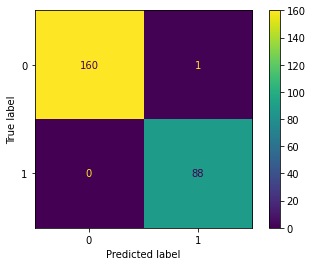

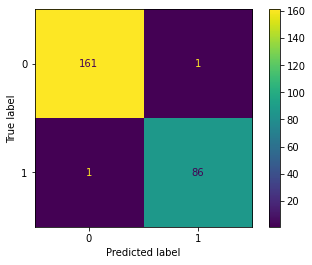

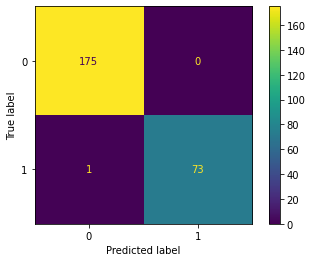

In [37]:
'''
Bayesian Model Evaluation

We use several evaluation metrics for the model.

'''
# Confusion matrix

# Convert test labels to numpy array, to match the y_pred format
y_test_np = y_test.to_numpy()

conf_labels=["Low", "Medium", "High"]
# Multilabel confusion matrix: we have 3 possible classes, we want a 2x2 matrix
confusion_matrix = metrics.multilabel_confusion_matrix(y_test_np, y_pred,labels=conf_labels)
# confusion_matrix

# Configuring multiple displays
for i,label in enumerate(conf_labels):
    display_i = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix[i])
    display_i.plot()
plt.show() 

In [38]:
# accuracy, precision, sensitivity/recall, specificity, F1 Score
# We use the "micro" average due to being working with a multiclass label

# Accuracy 
# Def: how often the model is correct
# Formula: (True Positive + True Negative) / Total Predictions
Accuracy = metrics.accuracy_score(y_test_np, y_pred)

# Precision
# Def: Of the positives PREDICTED, percentage TRULY positive
# Formula: True Positive / (True Positive + False Positive)
Precision = metrics.precision_score(y_test_np, y_pred,average="micro")

# Sensitivity / Recall 
# Def: Of all TRULY positives, percentage PREDICTED positive
# Formula: True Positive / (True Positive + False Negative)
Sensitivity_recall = metrics.recall_score(y_test_np, y_pred,average="micro")

# Specificity
# Def: Capacity of the model to predict negatives
# Formula: True Negative / (True Negative + False Positive)
Specificity = metrics.recall_score(y_test_np, y_pred, pos_label=0,average="micro")

# F-score
# Def: Harmonic mean of precision and sensitivity. "Average" capacity of dealing with positives
# Harmonic mean: reciprocal of the arithmetic mean numerators. It 
# is used because it can give the correct average in some scenarios,
# mostly those involving ratios. Example: average speed problem (found in
# GRE questions! )
# Original formula: (1/precision + 1/sensitivity) / 2 
# Also found as the equivalent: 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))
F1_score = metrics.f1_score(y_test_np, y_pred,average="micro")

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


{'Accuracy': 0.9919678714859438, 'Precision': 0.9919678714859438, 'Sensitivity_recall': 0.9919678714859438, 'Specificity': 0.9919678714859438, 'F1_score': 0.9919678714859438}


In [44]:
'''
Bayesian model

We build the model with the original variables and compare
'''
start_time=time.time()

# select original features 
features_orig=raw_data[features]

# we divide data in train and test 
x_train_orig,x_test_orig,y_train_orig,y_test_orig=train_test_split(features_orig,target,test_size=0.25,random_state=42)

# model training
model_orig=MultinomialNB()
model_orig.fit(x_train_orig,y_train_orig)

print(" training executed in %s seconds "% (time.time()-start_time))

# FASTER training with original variables

 training executed in 0.007996320724487305 seconds 


In [45]:
start_time=time.time()

# execute prediction
y_pred_orig=model_orig.predict(x_test_orig)
y_pred_orig

# accuracy
accuracy=accuracy_score(y_test_orig,y_pred_orig)
accuracy

print("Bayesian model with "+str(round(accuracy,4))+ " accuracy, executed in %s seconds "% (time.time()-start_time))

# SAME accuracy, with faster execution

Bayesian model with 0.996 accuracy, executed in 0.003996372222900391 seconds 


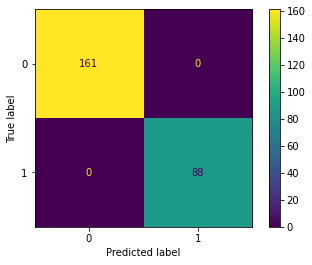

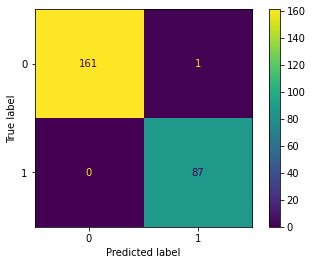

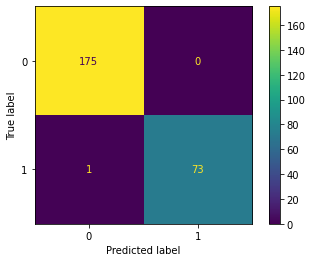

In [46]:
'''
Bayesian model Report
'''

# Confusion matrix

# Convert test labels to numpy array, to match the y_pred format
y_test_np_orig = y_test_orig.to_numpy()

conf_labels=["Low", "Medium", "High"]
# Multilabel confusion matrix: we have 3 possible classes, we want a 2x2 matrix
confusion_matrix_orig = metrics.multilabel_confusion_matrix(y_test_np_orig, y_pred_orig,labels=conf_labels)
# confusion_matrix

# Configuring multiple displays
for i,label in enumerate(conf_labels):
    display_i = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_orig[i])
    display_i.plot()
plt.show() 

In [42]:
# accuracy, precision, sensitivity/recall, specificity, F1 Score
# We use the "micro" average due to being working with a multiclass label

# Accuracy 
# Def: how often the model is correct
# Formula: (True Positive + True Negative) / Total Predictions
Accuracy = metrics.accuracy_score(y_test_np, y_pred)

# Precision
# Def: Of the positives PREDICTED, percentage TRULY positive
# Formula: True Positive / (True Positive + False Positive)
Precision = metrics.precision_score(y_test_np, y_pred,average="micro")

# Sensitivity / Recall 
# Def: Of all TRULY positives, percentage PREDICTED positive
# Formula: True Positive / (True Positive + False Negative)
Sensitivity_recall = metrics.recall_score(y_test_np, y_pred,average="micro")

# Specificity
# Def: Capacity of the model to predict negatives
# Formula: True Negative / (True Negative + False Positive)
Specificity = metrics.recall_score(y_test_np, y_pred, pos_label=0,average="micro")

# F-score
# Def: Harmonic mean of precision and sensitivity. "Average" capacity of dealing with positives
# Harmonic mean: reciprocal of the arithmetic mean numerators. It 
# is used because it can give the correct average in some scenarios,
# mostly those involving ratios. Example: average speed problem (found in
# GRE questions! )
# Original formula: (1/precision + 1/sensitivity) / 2 
# Also found as the equivalent: 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))
F1_score = metrics.f1_score(y_test_np, y_pred,average="micro")

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


{'Accuracy': 0.9919678714859438, 'Precision': 0.9919678714859438, 'Sensitivity_recall': 0.9919678714859438, 'Specificity': 0.9919678714859438, 'F1_score': 0.9919678714859438}


ValueError: Expected 'estimator' to be a binary classifier, but got ndarray

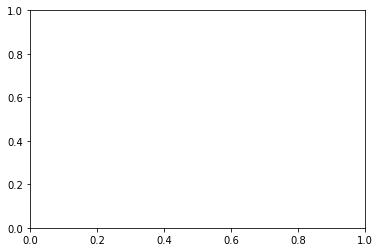

In [47]:
'''
Model comparison?

# Model with engineered features
{'Accuracy': 0.9959839357429718, 'Precision': 0.9959839357429718, 'Sensitivity_recall': 0.9959839357429718, 'Specificity': 0.9959839357429718, 'F1_score': 0.9959839357429718}

# Model with original features
{'Accuracy': 0.9959839357429718, 'Precision': 0.9959839357429718, 'Sensitivity_recall': 0.9959839357429718, 'Specificity': 0.9959839357429718, 'F1_score': 0.9959839357429718}
# same model??? 


In this case, we got an identically performing model using the original variables. The two models have very similar performance
even if using different feature sets. In this code, we see an example of how to use a data engineering and selection process 
with a dummy data set, with limited techniques used to generate features, a single model comparison, and with no iterations.
This work can be taken as a guide or base for future feature engineering processes for modeling.  
'''
